In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import t, shapiro
from scipy.stats import levene
import scipy.stats as stats

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df=pd.read_csv('billets.csv', sep=';')

In [3]:
df.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [5]:
doublons = df.duplicated()
# Utilisez la méthode any() pour vérifier s'il y a des doublons
sont_doublons = doublons.any()

if sont_doublons:
    print("Il y a des doublons dans le DataFrame.")
else:
    print("Il n'y a pas de doublons dans le DataFrame.")

Il n'y a pas de doublons dans le DataFrame.


In [6]:
df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [7]:
# Encoder la variable is_genuine
df['is_genuine'].replace([False,True], [0,1], inplace=True)
df.head()
#Pour m'assurer que dans  la regression logistique de statsmodel, la prediction des billets soit vrai et  faux 

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


<Axes: ylabel='margin_low'>

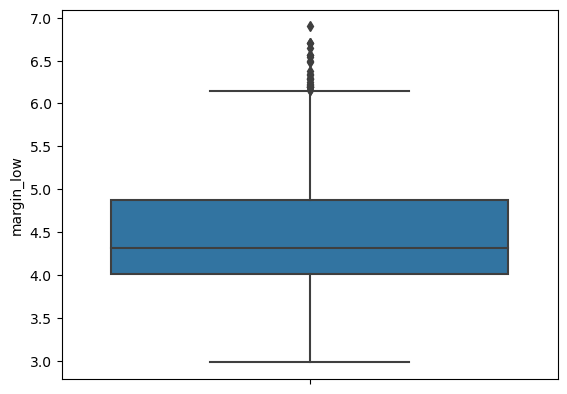

In [8]:
sns.boxplot(data=df,y='margin_low')

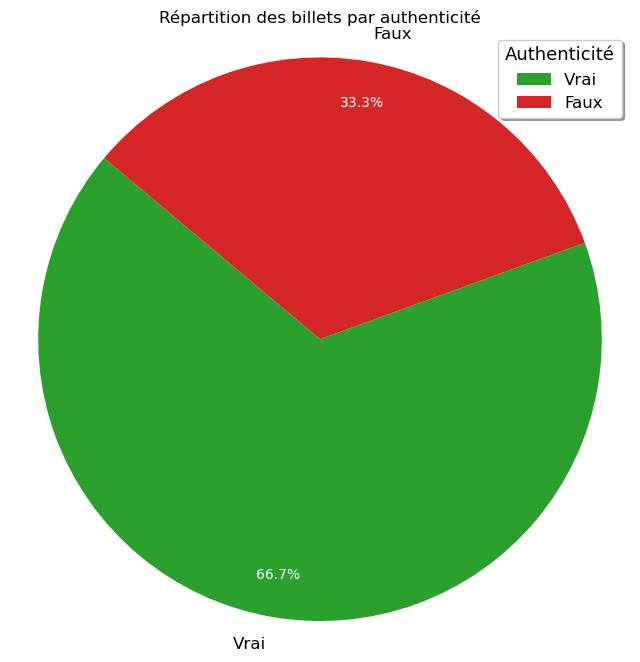

In [9]:
# Compter le nombre de vrais et de faux billets
count_genuine = df[df["is_genuine"] == 1].shape[0]
count_fake = df[df["is_genuine"] == 0].shape[0]

# Couleurs inversées des histogrammes
color_genuine = '#2ca02c'  # Vert pour les vrais billets
color_fake = '#d62728'     # Rouge pour les faux billets

# Créer le diagramme circulaire
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie([count_genuine, count_fake], labels=["Vrai", "Faux"], startangle=140,
                                   autopct='%1.1f%%', colors=[color_genuine, color_fake], pctdistance=0.85)
for autotext in autotexts:
    autotext.set_color('white')  # Mettre le pourcentage en blanc
plt.setp(texts, size=12)
plt.title('Répartition des billets par authenticité')
plt.legend(["Vrai", "Faux"], loc="upper right", fontsize=12, title="Authenticité", title_fontsize="13", shadow=True)
plt.axis('equal')  # Rendre le diagramme circulaire équivalent (cercle)
plt.show()

In [10]:
class_counts = df['is_genuine'].value_counts()

# Extraire les valeurs
count_genuine = class_counts[1]
count_fake = class_counts[0]
print(class_counts)

1    1000
0     500
Name: is_genuine, dtype: int64


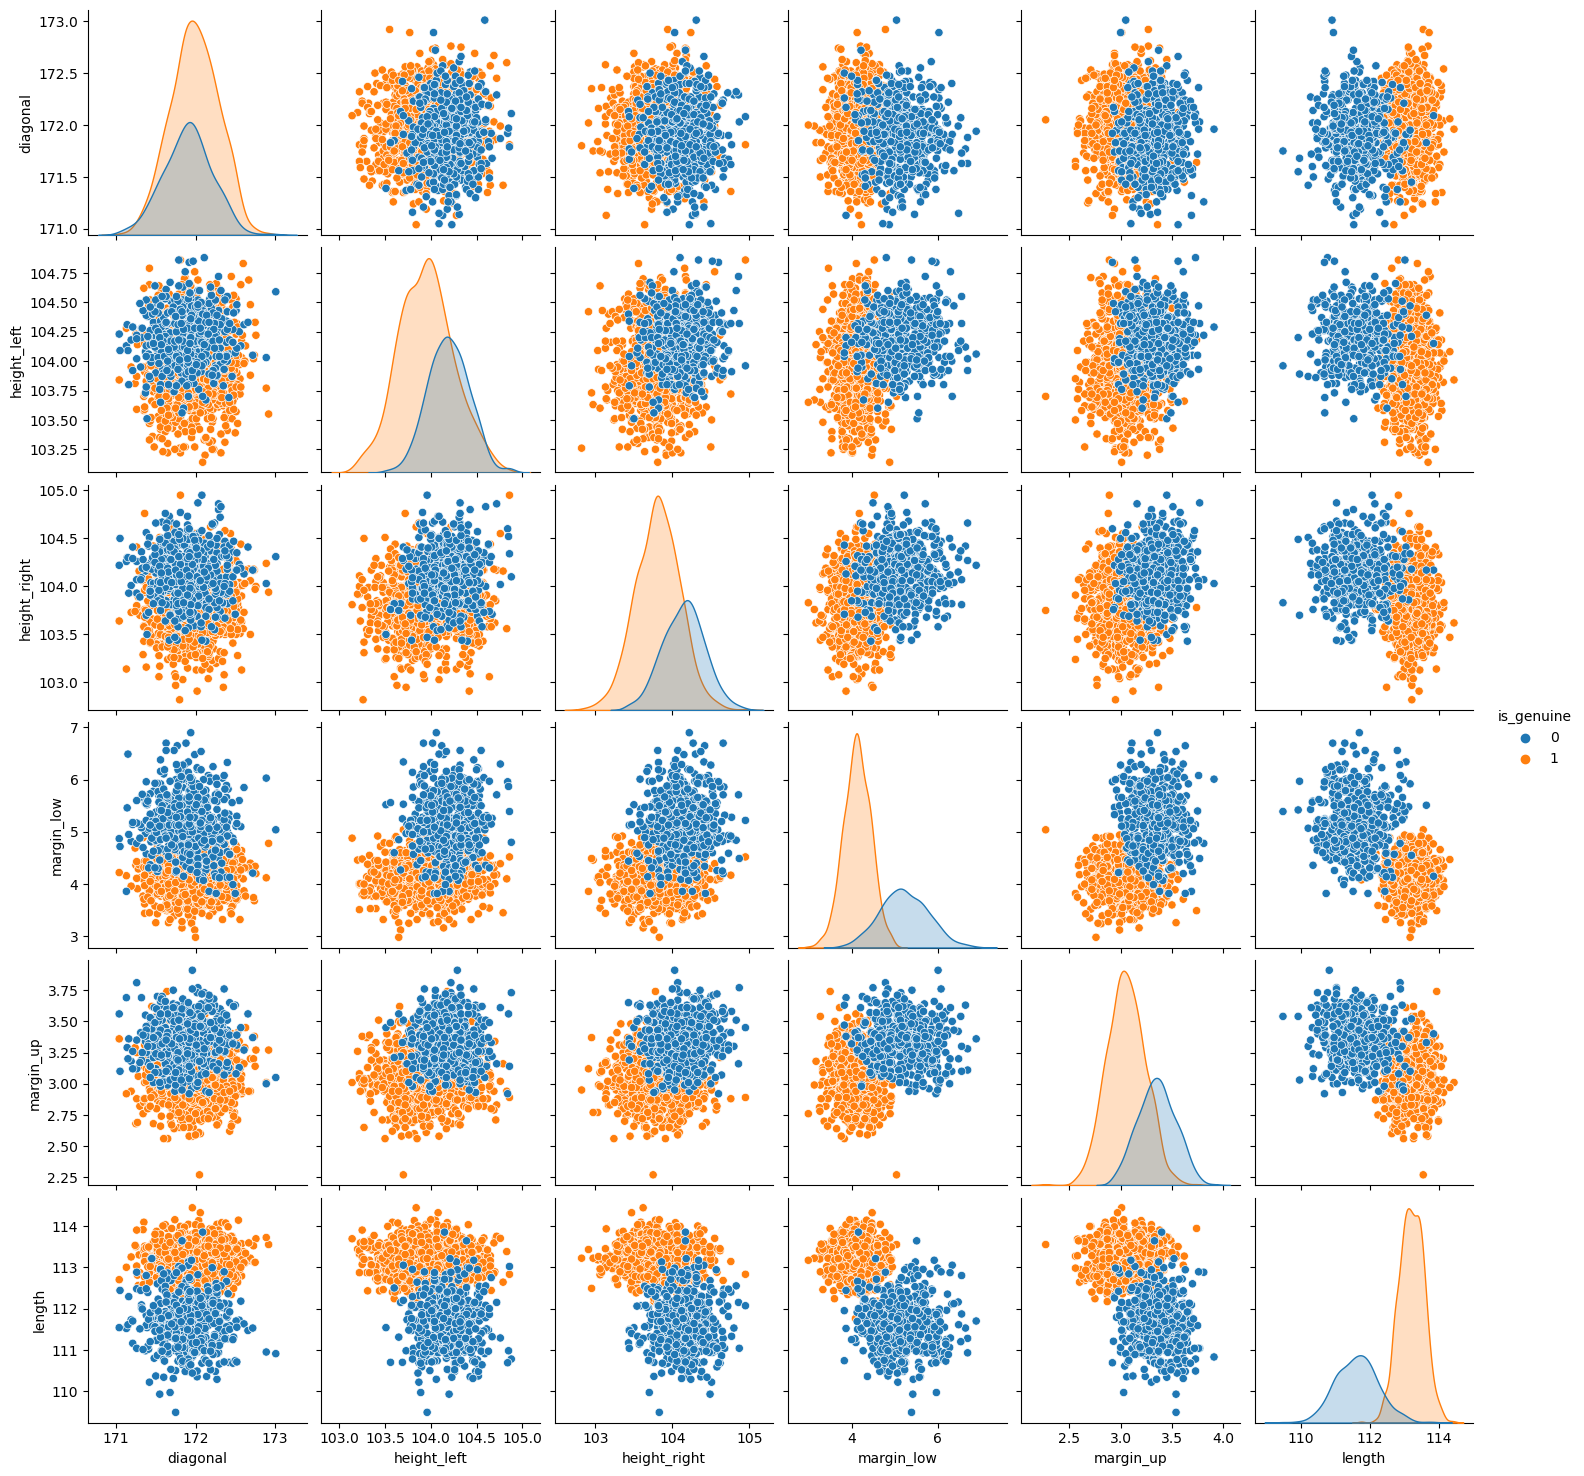

In [11]:
#créer une grille de tracés de paires où les points seront colorés en fonction de la valeur de la variable "is_genuine"
sns.pairplot(df, hue="is_genuine")

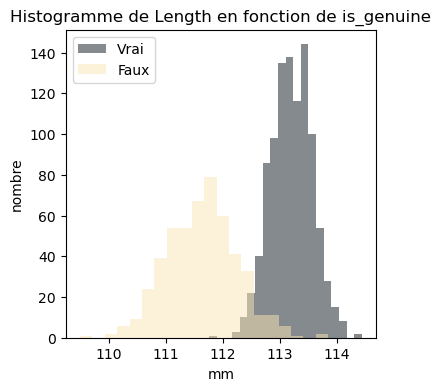

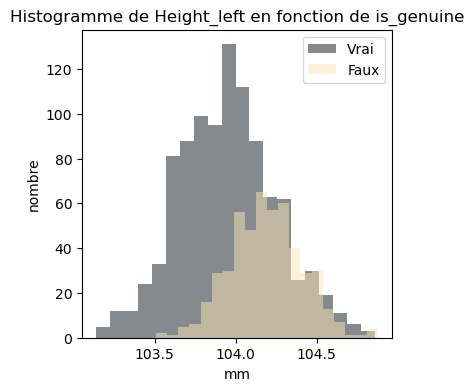

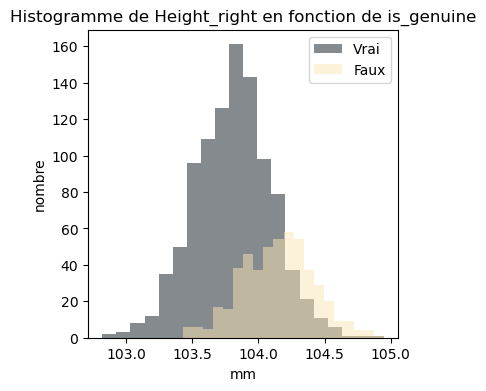

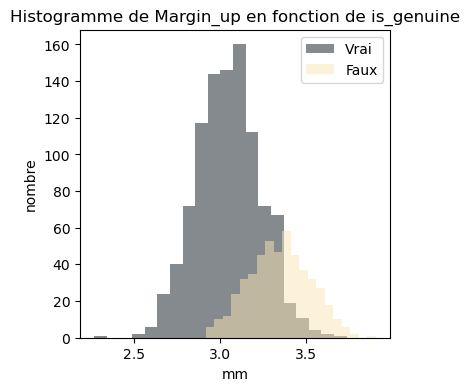

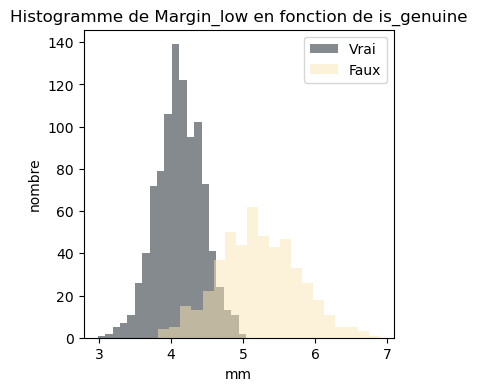

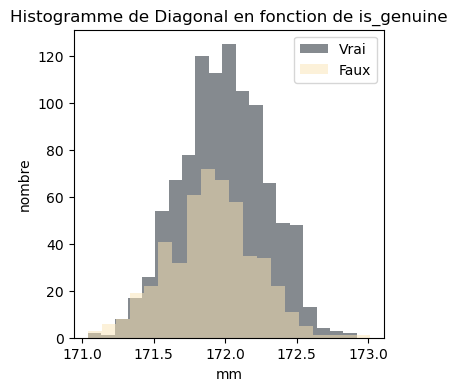

In [12]:
# Séparez les données en fonction de la valeur de is_genuine
genuine_data = df[df["is_genuine"] == 1]
fake_data = df[df["is_genuine"] == 0]

# Liste des variables géométriques
variables = ["length", "height_left", "height_right", "margin_up", "margin_low", "diagonal"]

# Créez les histogrammes pour chaque variable
for variable in variables:
    plt.figure(figsize=(4, 4))
    
    # Histogramme pour les vrais billets en bleu
    plt.hist(genuine_data[variable], bins=20, alpha=0.5, color='#0c1621', label='Vrai')
    
    # Histogramme pour les faux billets en or
    plt.hist(fake_data[variable], bins=20, alpha=0.5, color='#fbe4b4', label='Faux')  
    plt.xlabel('mm')
    plt.ylabel('nombre')
    plt.title(f'Histogramme de {variable.capitalize()} en fonction de is_genuine')
    plt.legend()
    
    plt.show()

In [13]:
# Définir les variables
variables = ["length", "height_left", "height_right", "margin_up", "margin_low", "diagonal"]

def print_variable_stats(variable, genuine_data, fake_data):
    print(f"Variable : {variable.capitalize()}")
    
    # Statistiques pour les vrais billets
    genuine_stats = genuine_data[variable].describe()
    print("Vrais billets :\n", genuine_stats)
    
    # Statistiques pour les faux billets
    fake_stats = fake_data[variable].describe()
    print("Faux billets :\n", fake_stats)
    
    print("=" * 40)

# Calcul des statistiques pour chaque variable
for variable in variables:
    print_variable_stats(variable, genuine_data, fake_data)


Variable : Length
Vrais billets :
 count    1000.000000
mean      113.202430
std         0.359552
min       111.760000
25%       112.950000
50%       113.205000
75%       113.460000
max       114.440000
Name: length, dtype: float64
Faux billets :
 count    500.000000
mean     111.630640
std        0.615543
min      109.490000
25%      111.200000
50%      111.630000
75%      112.030000
max      113.850000
Name: length, dtype: float64
Variable : Height_left
Vrais billets :
 count    1000.000000
mean      103.949130
std         0.300231
min       103.140000
25%       103.740000
50%       103.950000
75%       104.140000
max       104.860000
Name: height_left, dtype: float64
Faux billets :
 count    500.000000
mean     104.190340
std        0.223758
min      103.510000
25%      104.040000
50%      104.180000
75%      104.332500
max      104.880000
Name: height_left, dtype: float64
Variable : Height_right
Vrais billets :
 count    1000.00000
mean      103.80865
std         0.29157
min       

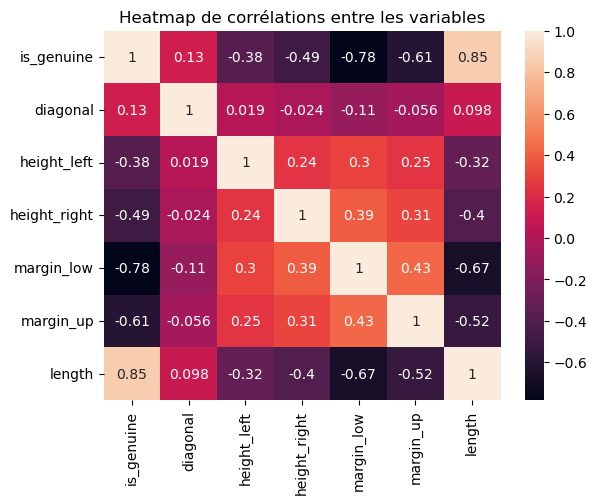

In [14]:
# Créer une heatmap de corrélations
sns.heatmap(df.corr(), annot=True)
plt.title("Heatmap de corrélations entre les variables")
plt.show()

On utilise le module statsmodels pour ajuster un modèle de régression linéaire

In [31]:
# Séparer les données en deux ensembles : un avec les valeurs manquantes pour 'margin_low' et un sans valeurs manquantes
data_missing = df[df['margin_low'].isnull()]
data_not_missing = df[~df['margin_low'].isnull()]

# Sélectionner les features et la cible pour les données non manquantes
X = data_not_missing[['length', 'height_left', 'height_right', 'margin_up', 'diagonal']]
y = data_not_missing['margin_low']

X = sm.add_constant(X)  # Ajouter une colonne constante pour l'interception dans le modèle

# Ajuster le modèle de régression linéaire en utilisant OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     274.9
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          1.17e-208
Time:                        19:40:52   Log-Likelihood:                -1015.0
No. Observations:                1500   AIC:                             2042.
Df Residuals:                    1494   BIC:                             2074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.3461      9.472      2.465   

R² est de 0.479, ce qui signifie que environ 48% de la variance de 'margin_low' est expliquée par les variables dans le modèle.
 Le variable " diagonal" a une P value > 5% on l'enleve.

In [41]:


# Séparer les données en deux ensembles : un ensemble contenant les valeurs manquantes pour 'margin_low' et un ensemble sans valeurs manquantes
data_missing = df[df['margin_low'].isnull()]
data_not_missing = df[~df['margin_low'].isnull()]

# Sélectionner les features et la cible pour les données non manquantes
X = data_not_missing[['length', 'height_left', 'height_right', 'margin_up']]
y = data_not_missing['margin_low']

X = sm.add_constant(X)  # Ajouter une colonne constante pour l'interception dans le modèle

# Ajuster le modèle de régression linéaire en utilisant OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Afficher un résumé des résultats de la régression
print(model.summary())

# Prédire les valeurs manquantes pour 'margin_low'
X_missing = data_missing[['length', 'height_left', 'height_right', 'margin_up']]
X_missing = sm.add_constant(X_missing)

predicted_missing = model.predict(X_missing)

# Remplacer les valeurs manquantes dans 'margin_low' par les valeurs prédites
df.loc[df['margin_low'].isnull(), 'margin_low'] = predicted_missing



                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     340.3
Date:                Fri, 29 Mar 2024   Prob (F-statistic):          2.49e-208
Time:                        20:04:40   Log-Likelihood:                -1018.8
No. Observations:                1500   AIC:                             2048.
Df Residuals:                    1495   BIC:                             2074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.4990      6.886      0.799   

In [42]:
#vérifier le nombre de valeurs manquantes dans la colonne 'margin_low' du DataFrame df.
print(df['margin_low'].isnull().sum())


0


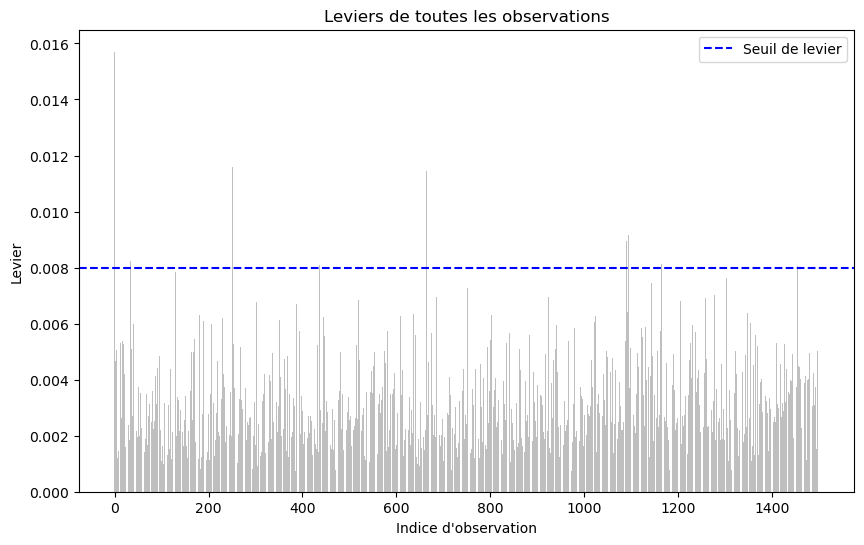

Observations potentiellement aberrantes basées sur les leviers :
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0              1    171.81       104.86        104.95     4.52000       2.89   
34             1    172.29       103.61        104.44     4.54000       2.69   
52             1    171.64       104.18        103.78     3.49000       3.74   
135            1    171.87       104.71        103.85     4.36000       2.71   
193            1    172.35       103.73        102.95     4.49000       3.37   
209            1    172.23       103.25        103.97     4.01000       3.38   
251            1    171.80       103.26        102.82     4.13783       2.95   
375            1    171.54       104.64        103.06     3.54000       3.09   
384            1    171.65       103.50        103.24     3.82000       2.56   
401            1    172.45       104.72        104.17     4.18000       2.83   
436            1    171.88       104.58        104.31  

In [43]:
# Calcul des leviers
leverage = model.get_influence().hat_matrix_diag

# Ajout des leviers au DataFrame
data_not_missing['leverage'] = leverage

# Seuil pour identifier les observations aberrantes
seuil_leverage = 2 * (X.shape[1] + 1) / X.shape[0]  # Seuil recommandé : (2 * (nombre de prédicteurs + 1)) / taille de l'échantillon

# Identifier les observations aberrantes en fonction du seuil de levier
outliers_leverage = data_not_missing[data_not_missing['leverage'] > seuil_leverage]

# Affichage des leviers de toutes les observations
plt.figure(figsize=(10, 6))
plt.bar(data_not_missing.index, data_not_missing['leverage'], color='gray', alpha=0.5)  # Crée un graphique à barres des leviers
plt.axhline(y=seuil_leverage, color='blue', linestyle='--', label='Seuil de levier')  # Ajoute une ligne horizontale pour le seuil de levier
plt.xlabel('Indice d\'observation')
plt.ylabel('Levier')
plt.title('Leviers de toutes les observations')
plt.legend()
plt.show()

# Affichage des observations potentiellement aberrantes
print("Observations potentiellement aberrantes basées sur les leviers :")
print(outliers_leverage)


In [44]:
nombre_outliers_leverage = outliers_leverage.shape[0]
print("Nombre d'observations potentiellement aberrantes basées sur les leviers :", nombre_outliers_leverage)


Nombre d'observations potentiellement aberrantes basées sur les leviers : 38


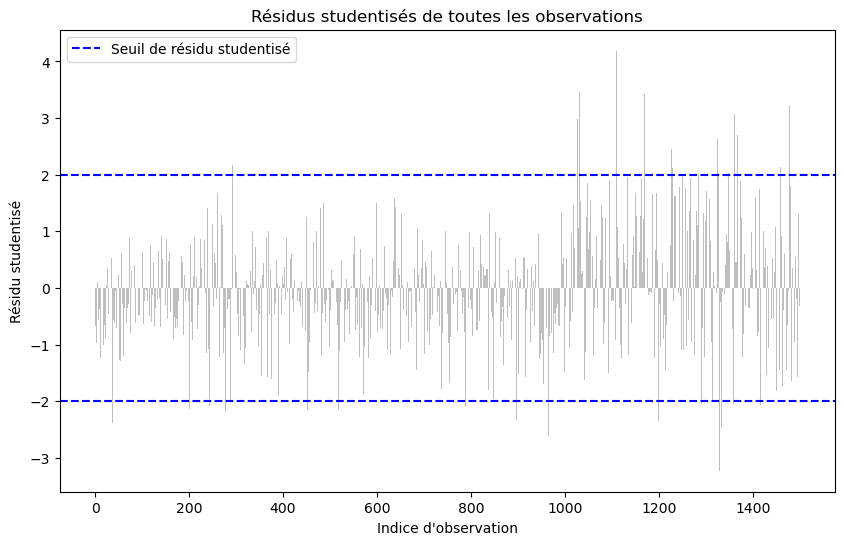

Nombre d'observations avec des résidus extrêmes : 79


In [45]:
# Calcul des résidus studentisés
studentized_residuals = model.get_influence().resid_studentized_internal

# Ajout des résidus studentisés au DataFrame
data_not_missing['studentized_residuals'] = studentized_residuals

# Affichage des résidus studentisés de toutes les observations
plt.figure(figsize=(10, 6))
plt.bar(data_not_missing.index, data_not_missing['studentized_residuals'], color='gray', alpha=0.5)
plt.axhline(y=2, color='blue', linestyle='--', label='Seuil de résidu studentisé')
plt.axhline(y=-2, color='blue', linestyle='--')
plt.xlabel('Indice d\'observation')
plt.ylabel('Résidu studentisé')
plt.title('Résidus studentisés de toutes les observations')
plt.legend()
plt.show()

# Calcul du nombre d'observations avec des résidus extrêmes
upper_threshold = 2  # Seuil supérieur
lower_threshold = -2  # Seuil inférieur
num_extreme_residuals = ((data_not_missing['studentized_residuals'] > upper_threshold) |
                         (data_not_missing['studentized_residuals'] < lower_threshold)).sum()

print(f"Nombre d'observations avec des résidus extrêmes : {num_extreme_residuals}")

 Les résidus studentisés sont des mesures de la distance entre les valeurs observées et les valeurs prédites du modèle, normalisées par leur erreur standard. Lorsqu'un résidu studentisé dépasse les seuils supérieur ou inférieur de 2 écarts-types (généralement définis à 2), il est considéré comme extrême.

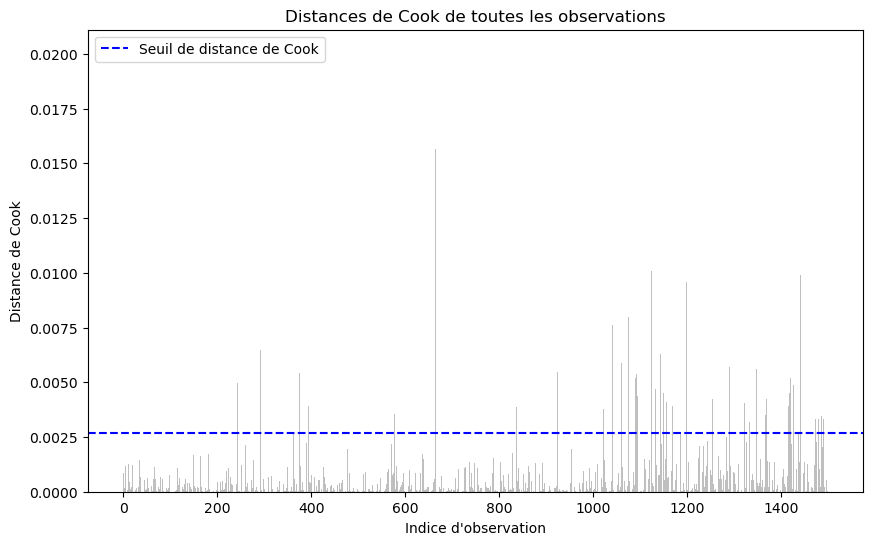

Nombre d'observations avec des distances de Cook supérieures au seuil : 83


In [46]:
# Calcul de la distance de Cook
cooks_distance, _ = model.get_influence().cooks_distance

# Ajout de la distance de Cook au DataFrame
data_not_missing['cooks_distance'] = cooks_distance

# Seuil pour identifier les observations influentes
seuil_cook = 4 / len(data_not_missing)  # Seuil recommandé : 4 / nombre d'observations

# Ajout de la distance de Cook au DataFrame
data_not_missing['cooks_distance'] = cooks_distance

# Affichage des distances de Cook de toutes les observations
plt.figure(figsize=(10, 6))
plt.bar(data_not_missing.index, data_not_missing['cooks_distance'], color='gray', alpha=0.5)
plt.axhline(y=seuil_cook, color='blue', linestyle='--', label='Seuil de distance de Cook')
plt.xlabel('Indice d\'observation')
plt.ylabel('Distance de Cook')
plt.title('Distances de Cook de toutes les observations')
plt.legend()
plt.show()

# Calcul du nombre d'observations avec des distances de Cook supérieures au seuil
num_observations_above_threshold = (data_not_missing['cooks_distance'] > seuil_cook).sum()

print(f"Nombre d'observations avec des distances de Cook supérieures au seuil : {num_observations_above_threshold}")

pour valider l'utilisation de la régression linéaire. Voici comment chacune des hypothèses peut être vérifiée
A.Hypothèse de la Normalité des résidus : Pour vérifier la normalité des résidus, il faut utiliser des méthodes graphiques telles que l'histogramme des résidus, un QQ plot (quantile-quantile plot) ou un graphique de densité des résidus. ou utiliser des tests statistiques formels tels que le test de Shapiro-Wilk pour évaluer si les résidus suivent une distribution normale.
B.Homoscédasticité : Pour vérifier l'homoscédasticité, par un graphique de résidus par rapport aux valeurs prédites (par exemple, un graphique de dispersion des résidus). Si la dispersion des résidus semble constante à différentes valeurs prédites, cela indique une homoscédasticité.  tests statistiques tels que le test de Breusch-Pagan ou le test de White pour évaluer l'homoscédasticité sont recommendés.
C.Multicolinéarité : La multicolinéarité peut être évaluée en examinant les corrélations entre les variables prédictives. Si deux variables prédictives sont fortement corrélées entre elles, cela peut indiquer une multicolinéarité.  Des méthodes telles que la matrice de corrélation ou le facteur d'inflation de la variance (VIF) pour évaluer la multicolinéarité entre les variables prédictives sont recommendés.

## A.Hypothèse de la Normalité des résidus

### A.1.Hypothèse de la Normalité des résidus par test de Shapiro-Wilk

In [47]:
from scipy import stats

residuals = model.resid

shapiro_test = stats.shapiro(residuals)
print("Statistique de test:", shapiro_test.statistic)
print("Valeur p:", shapiro_test.pvalue)

if shapiro_test.pvalue > 0.05:
    print("Les résidus semblent suivre une distribution normale.")
else:
    print("Les résidus ne suivent pas une distribution normale.")

Statistique de test: 0.985030472278595
Valeur p: 2.3573852939162698e-11
Les résidus ne suivent pas une distribution normale.


Le résultat du test de Shapiro-Wilk indique que les résidus ne suivent pas une distribution normale. Cela signifie que l'hypothèse de normalité des résidus est violée, ce qui peut affecter la validité des résultats obtenus à partir du modèle de régression linéaire.

Lorsque les résidus ne suivent pas une distribution normale, cela peut indiquer que le modèle ne capture pas correctement la structure des données ou que des violations d'autres hypothèses peuvent être présentes.                                       une valeur p aussi faible indique que la probabilité d'observer les données, ou des données plus extrêmes, si les résidus suivent une distribution normale, est extrêmement faible. 

### 2. Hypothèse de la Normalité des résidus par l'histogramme des résidus, un QQ plot 

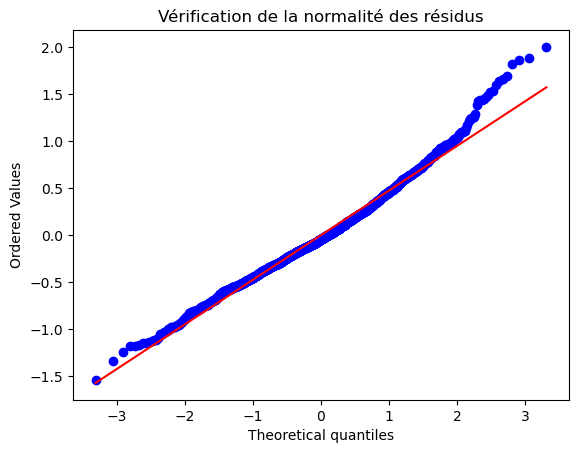

In [48]:
# Vérification de la normalité des résidus avec un Q-Q plot
residuals = model.resid
stats.probplot(residuals, plot=plt)
plt.title("Vérification de la normalité des résidus")
plt.show()

Ce graphique permet une évaluation visuelle de la normalité des résidus en comparant leur distribution à une distribution normale théorique. Si les points s'alignent de manière approximative avec la ligne diagonale, cela indique que les résidus suivent approximativement une distribution normale. Si les points s'écartent considérablement de la ligne diagonale, cela suggère une non-normalité des résidus. 

## B. L'hypothèse Homoscédasticité

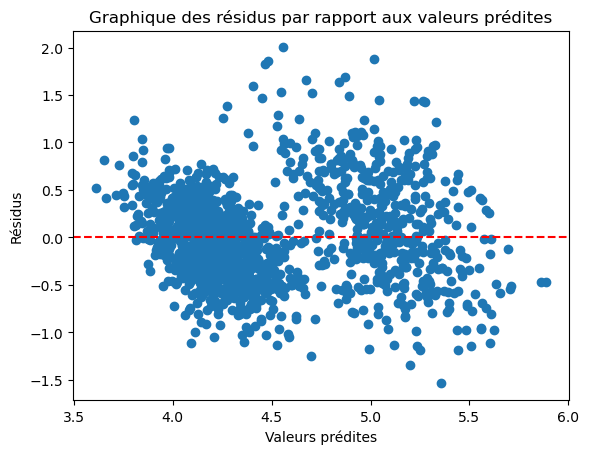

In [49]:
plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphique des résidus par rapport aux valeurs prédites")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

la présence de deux groupes distincts de points dans le graphique des résidus par rapport aux valeurs prédites suggère que la variance des résidus n'est pas constante à travers toutes les valeurs prédites, ce qui est une indication d'une violation de l'homoscédasticité.les résidus ne sont pas dispersés de manière uniforme autour de la ligne zéro sur le graphique des résidus par rapport aux valeurs prédites.

## C.L'hypothèse de Multicolinéarité

l'une des méthodes les plus avancées est le facteur d'inflation de la variance (VIF) peuvent être utilisées pour quantifier la gravité de la multicolinéarité.

In [50]:
# Importation de la fonction variance_inflation_factor depuis le module statsmodels.stats.outliers_influence
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sélection des variables explicatives 'margin_up' et 'is_genuine' de votre DataFrame 'data_not_missing' et les stocke dans 'X'
X = data_not_missing[['margin_up', 'is_genuine']]

# Création d'un DataFrame 'vif' pour stocker les résultats des calculs VIF
vif = pd.DataFrame()

# Ajout des noms des variables explicatives à la colonne "Variable" du DataFrame 'vif'
vif["Variable"] = X.columns

# Calcul du VIF pour chaque variable explicative dans 'X' en utilisant une boucle for pour chaque indice de colonne
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage du DataFrame 'vif' contenant les noms des variables explicatives et leurs VIF correspondants
print(vif)


     Variable       VIF
0   margin_up  2.645054
1  is_genuine  2.645054


En règle générale, un VIF inférieur à 5 est considéré comme acceptable et indique une absence de multicollinéarité significative. Dans ce cas, ce qui suggère qu' il n'y a pas de forte multicollinéarité à nous préoccuper dans notre modèle de régression linéaire.

# le modèle  

In [51]:
dff =df.copy()

In [52]:
# vérification des valeurs nulles
dff.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<Axes: ylabel='margin_low'>

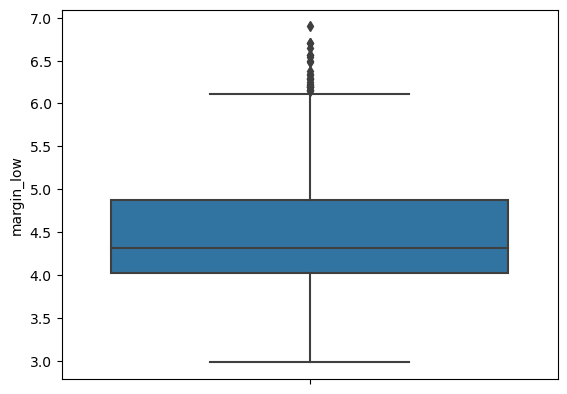

In [53]:
sns.boxplot(data=dff,y='margin_low')

In [54]:
# Importations
from sklearn.model_selection import train_test_split  # Importation de la fonction train_test_split pour diviser les données
from sklearn.metrics import confusion_matrix, classification_report  # Importation des outils d'évaluation des performances du modèle
import seaborn as sns  # Importation de la bibliothèque Seaborn pour la visualisation
import pickle  # Importation de la bibliothèque pickle pour la sérialisation


X_logistic = dff.drop(['is_genuine'], axis=1)  # Création du DataFrame des variables explicatives en excluant la variable cible
y_logistic = dff['is_genuine']  # Extraction de la variable cible


X_train, X_test, y_train, y_test = train_test_split(X_logistic, y_logistic, test_size=0.2, random_state=42)  # Division des données en ensembles d'entraînement et de test


X_train = sm.add_constant(X_train)  # Ajout d'une colonne constante aux données d'entraînement
X_test = sm.add_constant(X_test)  # Ajout d'une colonne constante aux données de test

logistic_model = sm.Logit(y_train, X_train).fit()  # Ajustement du modèle de régression logistique aux données d'entraînement

print(logistic_model.summary())  # Affichage du résumé du modèle de régression logistique


Optimization terminated successfully.
         Current function value: 0.028458
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.9549
Time:                        20:05:14   Log-Likelihood:                -34.149
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                4.162e-309
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -93.5468    263.799     -0.355      0.723    -610.584     423.490
diagonal        -0.288

les variables diagonal,height_left,height_right ont un p-valeurs supérieures à 0,05 ne sont pas considérés comme statistiquement significatifs au niveau de test de 5 %. 
le coefficient de détermination ajusté (R² ) est de 0,9548 indique que près de 95,48 % de la variabilité de la variable dépendante "is_genuine" est expliquée par les variables indépendantes incluses dans le modèle.

par conséquence enlève les variables non significatives.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle

# Sélection des variables pour la régression logistique
X_logistic = dff.drop(['is_genuine', 'height_left', 'diagonal'], axis=1)
y_logistic = dff['is_genuine']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_logistic, y_logistic, test_size=0.2, random_state=42)

# Ajout de la constante pour la régression logistique
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Régression Logistique avec statsmodels
logistic_model = sm.Logit(y_train, X_train).fit()
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.028983
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.9540
Time:                        20:05:15   Log-Likelihood:                -34.780
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                2.159e-311
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -249.7828    151.710     -1.646      0.100    -547.129      47.563
height_right    -3.294

Test d'hypothèse 
La variable de réponse est binaire/quali : Is_genuine est bien binaire (oui/non)
La taille de l'échantillon doit être suffisante: En règle générale, on souhaite avoir plus de 500 observations indépendantes et plus de 20 observations pour l'outcome la moins fréquente. C'est le cas ici puisque nous avons 1500 observations dont 500 faux billets.
Les observations sont indépendantes : Ici nos billets sont uniques et indépendants des autres
Test de multicolinéarité :

On fait de nouveau le test de multicolinéarité

In [56]:
# Calcul des VIF pour chaque variable dans X_train (sans la constante)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns[1:]  # Exclure la constante
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i+1) for i in range(X_train.shape[1]-1)]

print(vif_data)

        feature       VIF
0  height_right  1.239585
1    margin_low  1.890715
2     margin_up  1.413881
3        length  2.191049


 Tous les VIF sont inférieurs au seuil 5, ce qui suggère qu'il n'y a pas de forte multicollinéarité entre les variables explicatives dans ce modèle

### Évaluation de la performance du modèle de régression logistique sur le jeu de test

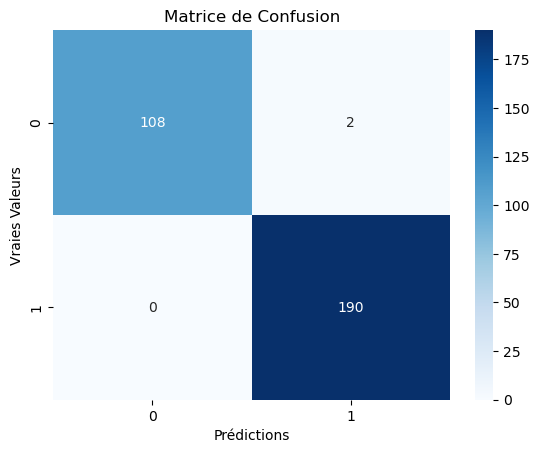

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       110
           1       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [57]:
# Prédictions sur le jeu de test
y_pred = logistic_model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Matrice de Confusion en Heatmap
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Rapport de Classification
print(classification_report(y_test, y_pred_binary))

In [58]:
from sklearn.metrics import f1_score
# On définit notre model
model_01 = LogisticRegression()

# On entraine notre model
model_01 = model_01.fit(X_train, y_train)

# On enregistre les prédictions dans une variable y_pred
y_pred = model_01.predict(X_test)

# On vérifie le score de notre model sur les données Test (F1 score)
score_f1 = f1_score(y_test, y_pred)
score_f1 = round(score_f1*100,4)
print("Le score de notre model sur les données Test est de :", score_f1,"%")

Le score de notre model sur les données Test est de : 99.2167 %


les moyennes sont également de 99 %, ce qui indique une très bonne performance globale du modèle.

### évaluation comment le modèle se comporte sur les données sur lesquelles il a été entraîné. 

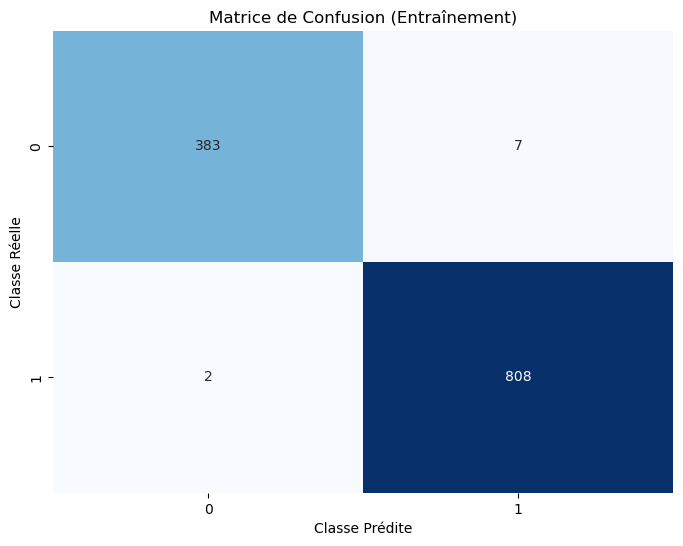

In [59]:
# Prédiction des classes sur l'ensemble d'entraînement
y_train_pred = logistic_model.predict(X_train)
y_train_pred_class = (y_train_pred > 0.5).astype(int)

# Création de la matrice de confusion pour l'ensemble d'entraînement
confusion_train = confusion_matrix(y_train, y_train_pred_class)

# Création d'un heatmap pour la matrice de confusion de l'ensemble d'entraînement
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion (Entraînement)')
plt.show()

In [60]:
from sklearn.metrics import accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(y_train, y_train_pred_class)

# Affichage de l'accuracy
print("Accuracy sur l'ensemble d'entraînement :", accuracy)


Accuracy sur l'ensemble d'entraînement : 0.9925


### Calcul des probabilités prédites et ajustement pour les billets faux 

In [61]:
# Prédire les classes et les probabilités
dff['predicted_class'] = logistic_model.predict(sm.add_constant(X_logistic)) >= 0.5
dff['predicted_probability'] = logistic_model.predict(sm.add_constant(X_logistic))

# Ajuster les probabilités pour les billets faux
dff['predicted_probability'] = dff.apply(lambda row: 1 - row['predicted_probability'] if not row['predicted_class'] else row['predicted_probability'], axis=1)

# Arrondir les probabilités à 5 décimales
dff['predicted_probability'] = dff['predicted_probability'].round(5)

# Afficher le DataFrame avec les nouvelles colonnes
print(dff)


      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0              1    171.81       104.86        104.95        4.52       2.89   
1              1    171.46       103.36        103.66        3.77       2.99   
2              1    172.69       104.48        103.50        4.40       2.94   
3              1    171.36       103.91        103.94        3.62       3.01   
4              1    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495           0    171.75       104.38        104.17        4.42       3.09   
1496           0    172.19       104.63        104.44        5.27       3.37   
1497           0    171.80       104.01        104.12        5.51       3.36   
1498           0    172.06       104.28        104.06        5.17       3.46   
1499           0    171.47       104.15        103.82        4.63       3.37   

      length  predicted_class  predicte

### Dernière vérification avec le courbe ROC

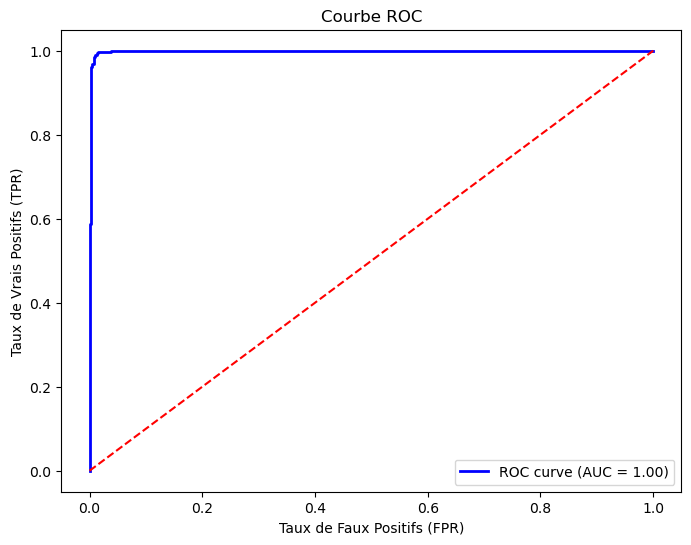

In [62]:
from sklearn.metrics import roc_curve, auc

# Calcul des taux de faux positifs (FPR) et des taux de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


In [63]:
#sauvegarde le modèle logistique dans un fichier 
with open('logistic_model.pkl', 'wb') as model_file:
    pickle.dump(logistic_model, model_file)

# K Means

K-means est un algorithme non supervisé de clustering non hiérarchique. Il permet de regrouper en K clusters distincts les observations du data set. L'objectif principal de l'algorithme est de minimiser la variance intra-cluster, c'est-à-dire de minimiser la distance entre les points de données à l'intérieur d'un même cluster.

#### Détermination du nombre optimal de clusters avec la méthode du coude pour le clustering K-means 

C:\Users\ghait\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ghait\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\ghait\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ghait\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

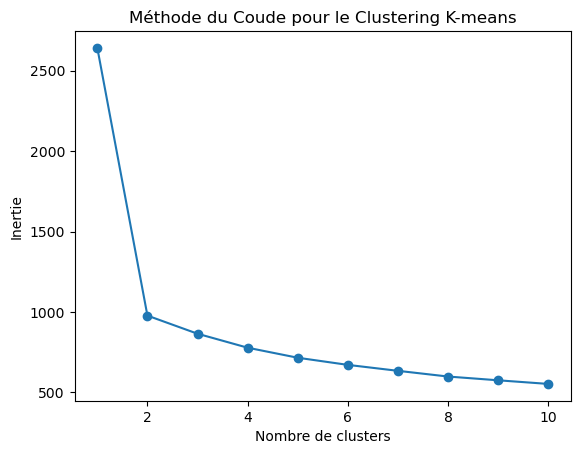

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Sélection des variables pour le clustering K-means
X_kmeans = dff.drop(['is_genuine'], axis=1)

# Trouver le nombre optimal de clusters en utilisant la méthode du coude
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_kmeans)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du coude
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour le Clustering K-means')
plt.show()

In [65]:

# Définition du nombre de clusters
num_clusters = 2

# Initialisation de l'algorithme K-means avec le nombre de clusters spécifié et une graine aléatoire
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Clustering des données en utilisant l'algorithme K-means
# Les données sont ajustées et chaque observation est assignée à un cluster
dff['cluster'] = kmeans.fit_predict(X_kmeans)


C:\Users\ghait\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ghait\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


#### Évaluation des performances du modèle de clustering K-means avec une matrice de confusion

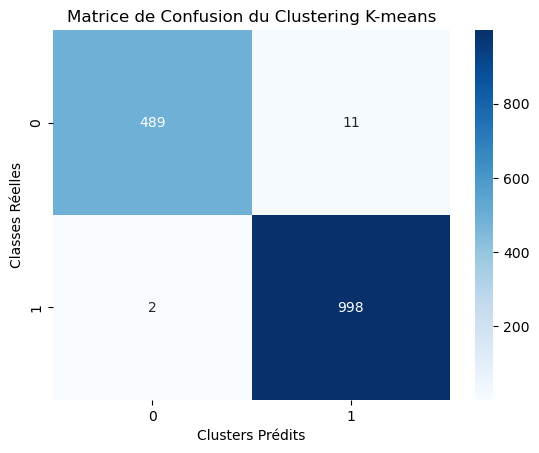

Score du modèle K-means: 0.9913333333333333


In [66]:
from sklearn.metrics import confusion_matrix

# Création de la matrice de confusion
conf_matrix_kmeans = confusion_matrix(dff['is_genuine'], dff['cluster'])

# Affichage de la matrice de confusion en heatmap
sns.heatmap(conf_matrix_kmeans, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clusters Prédits')
plt.ylabel('Classes Réelles')
plt.title('Matrice de Confusion du Clustering K-means')
plt.show()

# Calcul du score du modèle K-means
accuracy_kmeans = sum(dff['is_genuine'] == dff['cluster']) / len(dff)
print("Score du modèle K-means:", accuracy_kmeans)

# Le choix du modèle 

Le score de  model Regression logistique est de : 99.2167 %
Le score de  model Kmeans est de : 99.1333 %
                           je vais prendre en compte le modele regression logistique